# Algorithmic Trading Model for Simple Trend-Following Strategy with Stock Combo
### David Lowe
### January 13, 2021

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model examines a simple trend-following strategy for a stock. The model buys a stock when the price reaches the highest price for the last X number of days. The model will exit the position when the stock price crosses below the mean of the same window size.

In this Take1 iteration, we will set up the models using one fixed window size for each model. The window size will vary from 10 to 50 trading days at a 5-day increment.

ANALYSIS: From this iteration, we analyzed the stock prices for Apple Inc. (AAPL) between January 1, 2019, and December 24, 2020. The trading model produced a profit of 79.07 dollars per share. The buy-and-hold approach yielded a gain of 90.18 dollars per share.

CONCLUSION: For the stock of AAPL during the modeling time frame, the trading strategy did not produce a better return than the buy-and-hold approach. We should consider modeling this stock further by experimenting with more variations of the strategy.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Quandl

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Implement and Train Models
4. Back-test Models
5. Evaluate Strategy Performance

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
#
# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Retrieve the CPU information
# ncpu = !nproc
# print("The number of available CPUs is:", ncpu[0])

### 1.a) Load libraries and modules

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import date, datetime, timedelta
import requests
import json
from dotenv import load_dotenv
# import pandas_datareader.data as pdr

# Begin the timer for the script processing
startTimeScript = datetime.now()

### 1.b) Set up the controlling parameters and functions¶

In [6]:
# Specify the key modeling parameters below
STOCK_LIST = ['FB','AAPL','TSLA','MSFT','AMZN','GOOGL','NFLX','NVDA']
DEFAULT_SYMBOL = 'AAPL'
INITIAL_CAPITAL = 0

# Specify the moving average parameters for the trading strategy
WINDOW_MIN = 10
WINDOW_MAX = 50
WINDOW_INCREMENT = 5
VOL_MA_MIN = 10
VOL_MA_MAX = 10
VOL_MA_INCREMENT = 1

# The number of extra days of data we need for calculating moving averages (usually equals to the largest value of slow MA)
EXTRA_DAYS = WINDOW_MAX

MODEL_START_DATE = date(2019, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

MODEL_END_DATE = datetime.now().date()
# MODEL_END_DATE = date(2020, 11, 20)
print("Ending date for the model:", MODEL_END_DATE)

# data_start_date = MODEL_START_DATE
data_start_date = MODEL_START_DATE - timedelta(days=int(EXTRA_DAYS * 1.5)) # Need more pricing data to calculate moving averages
print("First date of data we need for modeling:", data_start_date)

data_end_date = MODEL_END_DATE
print("Last date of data we need for modeling:", data_end_date)

Starting date for the model: 2019-01-01
Ending date for the model: 2020-12-24
First date of data we need for modeling: 2018-10-18
Last date of data we need for modeling: 2020-12-24


In [7]:
# Specify the script running parameters below

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Configure the plotting style
plt.style.use('seaborn')

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
VERBOSE_HISTORY = False
VERBOSE_MODELS = False
VERBOSE_SIGNALS = False
VERBOSE_GRAPHS = False
VERBOSE_PORTFOLIOS = False
VERBOSE_TRANSACTIONS = False
VERBOSE_POSITIONS = False

In [8]:
# Set up the parent directory location for loading the dotenv files

# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up access to the dotenv file on local PC
env_path = "/Users/david/PycharmProjects/"
dotenv_path = env_path + "python_script.env"
load_dotenv(dotenv_path=dotenv_path)

True

## Task 2 - Acquire and Pre-Process Data

In [9]:
def task2_build_template(ticker=DEFAULT_SYMBOL):
    # Set up the data service provider and data acquisition parameters
    data_service = 'Quandl'

    # Check and see whether the API key is available
    api_key = os.environ.get('QUANDL_API')
    if api_key is None: sys.exit("API key for Quandl not available. Script Processing Aborted!!!")

    start_date_string = data_start_date.strftime('%Y-%m-%d')
    end_date_string = data_end_date.strftime('%Y-%m-%d')
    api_url = "https://www.quandl.com/api/v3/datatables/SHARADAR/SEP.json?date.gte=%s&date.lte=%s&ticker=%s&api_key=%s" % (start_date_string, end_date_string, ticker, api_key)
    response = requests.get(api_url)
    resp_dict = json.loads(response.text)
    stock_rawdata = pd.DataFrame(resp_dict['datatable']['data'])
    if VERBOSE_HISTORY: print(len(stock_rawdata), 'data points retrieved from the API call.')

    stock_rawdata.columns = ['ticker', 'date', 'open', 'high', 'low', 'close', 'volume', 'dividend', 'closeunadj', 'lastupdated']
    # stock_rawdata.set_index('date', inplace=True)
    stock_rawdata.index = pd.to_datetime(stock_rawdata.date)
    stock_pricing = stock_rawdata.sort_index(ascending=True)
    if VERBOSE_HISTORY:
        print(stock_pricing.head(), '\n', stock_pricing.tail(), '\n')

    # Set up the standard column name for modeling
    # Column names may be data-provider specific!
    template = stock_pricing.loc[:, ['open','close','volume']]
    template.rename(columns={'open': 'open_price', 'close': 'close_price', 'volume': 'trading_volume'}, inplace=True)
    if VERBOSE_HISTORY:
        plot_title = 'Historical Stock Close Price for ' + ticker + ' from ' + data_service
        template['close_price'].plot(figsize=(16,9), title=plot_title)
        plt.show()
    return template

## Task 3 - Implement and Train Models

In [10]:
# Define the function that will generate the indicators and trading signals
def task3_populate_signals(template, window=WINDOW_MIN, vol_ma=VOL_MA_MIN):

    trade_model = template.copy()
    trade_model['window_high'] = trade_model['close_price'].shift(1).rolling(window=window).max()
    trade_model['window_low'] = trade_model['close_price'].shift(1).rolling(window=window).min()
    trade_model['window_avg'] = trade_model['close_price'].shift(1).rolling(window=window).mean()
    trade_model['volume_ma'] = trade_model['trading_volume'].rolling(vol_ma).mean()
    trade_model['trade_signal'] = 0
    trade_model['entry_exit'] = 0
    prior_signal = 0
    prior_ownership = False
    currently_own = False

    # Truncate the model to the required starting and ending dates
    trade_model = trade_model[MODEL_START_DATE:MODEL_END_DATE]

    for k in range(len(trade_model)):
        current_signal = 0
        breakout = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_high']
        crossover = trade_model.at[trade_model.index[k],'close_price'] - trade_model.at[trade_model.index[k],'window_avg']
        trade_volume = trade_model.at[trade_model.index[k],'trading_volume']
        average_volume = trade_model.at[trade_model.index[k],'volume_ma']
        trade_model.at[trade_model.index[k],'entry_exit'] = prior_signal
        if prior_signal == 1:
            currently_own = True
        elif  prior_signal == -1:
            currently_own = False
        else:
            currently_own = prior_ownership

        if (breakout > 0) and (trade_volume > average_volume) and (not currently_own):
            current_signal = 1  # trade_signal = 1 means we should buy
            currently_own = True
        elif (crossover < 0) and (trade_volume > average_volume) and currently_own:
            current_signal = -1  # trade_signal = -1 means we should sell
            currently_own = False
        trade_model.at[trade_model.index[k],'trade_signal'] = current_signal
        prior_signal = current_signal
        prior_ownership = currently_own

    # Exiting the position on the last day of modeling period
    if currently_own:
        trade_model.at[trade_model.index[-1],'entry_exit'] = -1
    if VERBOSE_MODELS: print(trade_model, '\n')
    return trade_model

In [11]:
# List the entry/exit points for each model
def task3_list_model_entry_exit(trade_model):
    print(trade_model[(trade_model['trade_signal'] != 0) | (trade_model['entry_exit'] != 0)])

In [12]:
def task3_draw_model_graph(trade_model, mdl_name):
    graph_data = trade_model.copy()
    title_string = 'Trend-Following Trading Model for ' + mdl_name
    fig = plt.figure(figsize=(16,9))
    ylabel = 'Stock Price in $'
    ax1 = fig.add_subplot(111, ylabel=ylabel, title=title_string)
    graph_data['close_price'].plot(ax=ax1, color='g')
    ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
    ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
    plt.legend(loc='upper left')
    plt.show()

## Task 4 - Back-test Models

In [13]:
def task4_generate_trading_portfolios(trade_model):
    # Construct a portfolio to track the transactions and returns
    portfolio = pd.DataFrame(index=trade_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction', 'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accum_return'])
    portfolio.iloc[0]['trade_action'] = 0
    portfolio.iloc[0]['qty_onhand'] = 0
    portfolio.iloc[0]['cost_basis'] = 0.00
    portfolio.iloc[0]['sold_transaction'] = 0.00
    portfolio.iloc[0]['gain_loss'] = 0.00
    portfolio.iloc[0]['cash_onhand'] = INITIAL_CAPITAL
    portfolio.iloc[0]['position_value'] = 0.00
    portfolio.iloc[0]['total_position'] = INITIAL_CAPITAL
    portfolio.iloc[0]['accum_return'] = portfolio.iloc[0]['total_position'] - INITIAL_CAPITAL
    recent_cost = 0

    # The conditional parameters below determine how the trading strategy will be carried out
    for i in range(1, len(portfolio)):
        if (trade_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
            portfolio.iloc[i]['trade_action'] = 1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
            recent_cost = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
            if VERBOSE_PORTFOLIOS: print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        elif (trade_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
            portfolio.iloc[i]['trade_action'] = -1
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
            portfolio.iloc[i]['cost_basis'] = 0.00
            portfolio.iloc[i]['sold_transaction'] = trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
            portfolio.iloc[i]['gain_loss'] = (recent_cost + (trade_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
            recent_cost = 0.00
            if VERBOSE_PORTFOLIOS: print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trade_model.iloc[i]['open_price'])
        else:
            portfolio.iloc[i]['trade_action'] = 0
            portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
            portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
            portfolio.iloc[i]['sold_transaction'] = 0.00
            portfolio.iloc[i]['gain_loss'] = 0.00
            portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
        portfolio.iloc[i]['position_value'] = trade_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
        portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
        portfolio.iloc[i]['accum_return'] = portfolio.iloc[i]['total_position'] - INITIAL_CAPITAL

    if VERBOSE_PORTFOLIOS: print('\n', portfolio, '\n')
    return portfolio

In [14]:
def task4_calculate_positions_and_performance(trade_model):
    trade_positions = task4_generate_trading_portfolios(trade_model)
    trade_transactions = trade_positions[trade_positions['trade_action'] != 0]
    if VERBOSE_TRANSACTIONS: print(trade_transactions)
    if VERBOSE_TRANSACTIONS:
        if trade_transactions.iloc[-1]['trade_action'] == 1:
            print('The current status of the model is:', 'Holding a position since', trade_transactions.index.tolist()[-1].date(), '\n')
        else:
            print('The current status of the model is:', 'Waiting to enter since', trade_transactions.index.tolist()[-1].date(), '\n')
    return trade_positions

## Task 5 - Evaluate Strategy Performance

9 trading models generated for FB.

9 sets of model positions generated for FB.

9 profit/loss summaries generated.

A summary of the top model's performance:
                  Model_name  Return_value Return_percentage
0  FB_002_WINDOW_15_VOLMA_10        50.228              None
8  FB_009_WINDOW_50_VOLMA_10        48.815              None
1  FB_008_WINDOW_45_VOLMA_10        33.985              None
2  FB_004_WINDOW_25_VOLMA_10        30.863              None
3  FB_005_WINDOW_30_VOLMA_10        28.733              None 

The entry point for the buy-and-hold model: $128.99 on 2019-01-02
The exit point for the buy-and-hold model: $268.88 on 2020-12-24
The performance of the buy-and-hold model: $139.88
The performance of the top trading model: $50.23

           trade_action qty_onhand cost_basis sold_transaction gain_loss cash_onhand position_value total_position accum_return
date                                                                                                             

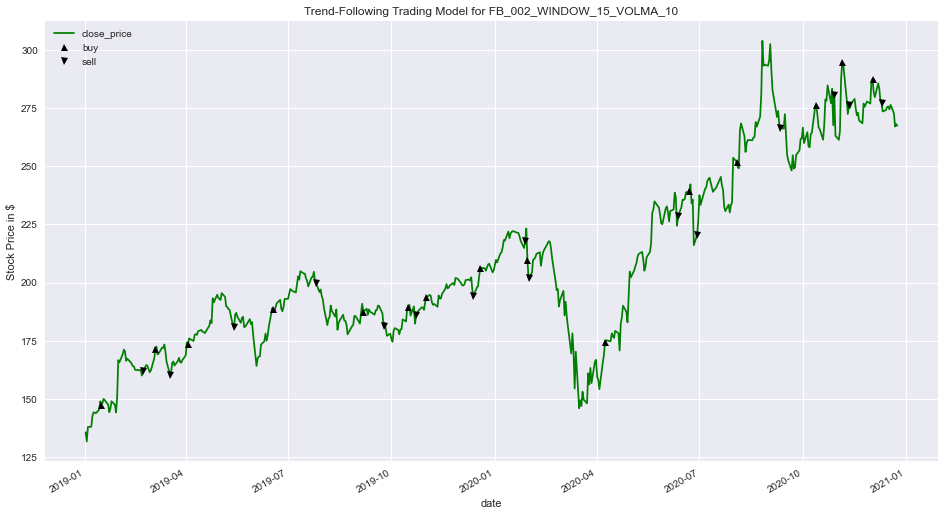

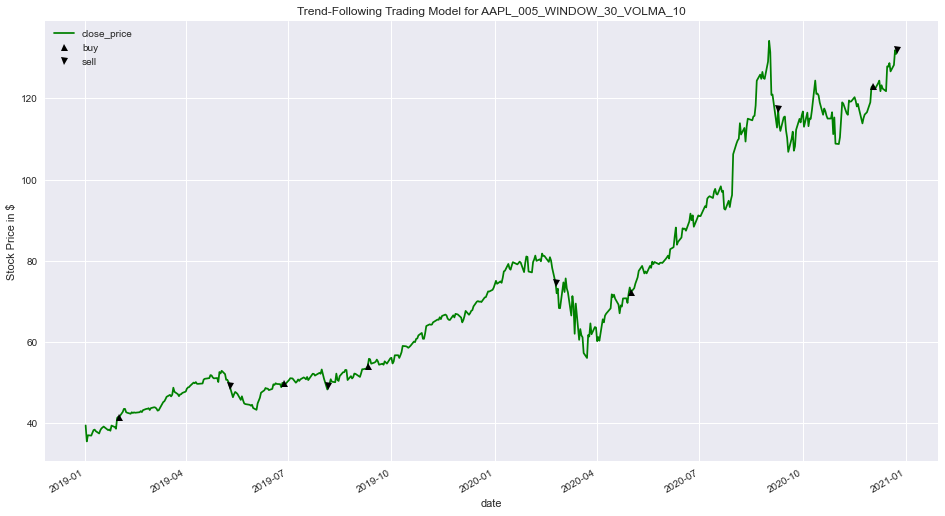

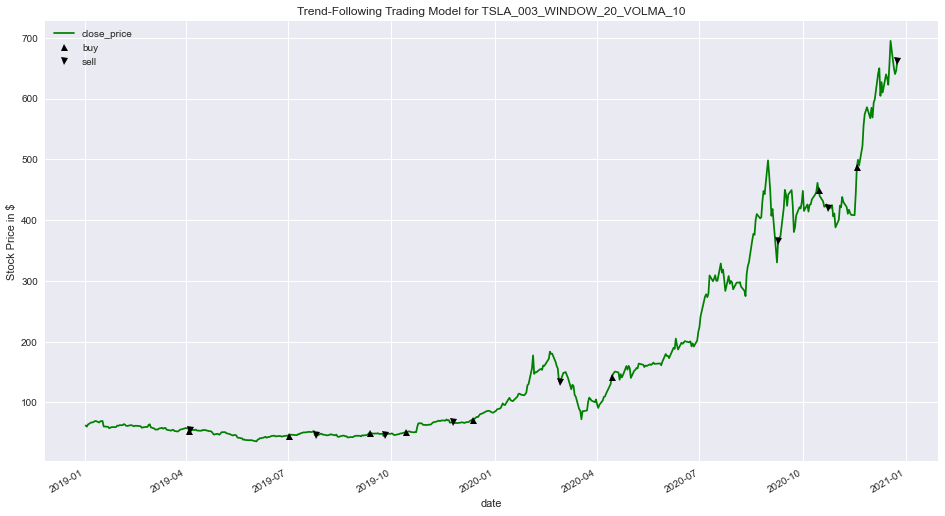

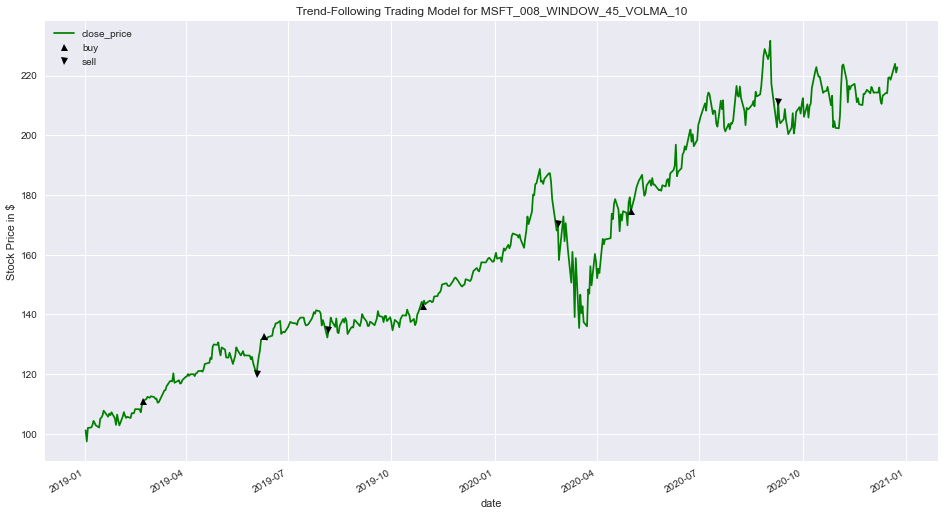

In [ ]:
if __name__ == "__main__":
    for stock_symbol in STOCK_LIST:
        model_template = task2_build_template(stock_symbol)

        # Build the collection of trading models by iterating through the parameters
        trading_model_collection = {}
        serial_no = 0
        for window_size in range(WINDOW_MIN, WINDOW_MAX+1, WINDOW_INCREMENT):
            for vol_average in range(VOL_MA_MIN, VOL_MA_MAX+1, VOL_MA_INCREMENT):
                serial_no += 1
                model_tag = stock_symbol + '_' + str(serial_no).zfill(3) + '_WINDOW_' + str(window_size).zfill(2) + '_VOLMA_' + str(vol_average).zfill(2)
                if VERBOSE_MODELS: print('Processing model:', model_tag)
                trading_model = task3_populate_signals(model_template, window_size, vol_average)
                trading_model_collection[model_tag] = trading_model.copy()
        print(len(trading_model_collection), 'trading models generated for', stock_symbol+'.\n')

        if VERBOSE_SIGNALS:
            for model_name in trading_model_collection:
                print('List the signal changes and entry/exit points for model:', model_name)
                task3_list_model_entry_exit(trading_model_collection[model_name])
                print()

        if VERBOSE_GRAPHS:
            for model_name in trading_model_collection:
                task3_draw_model_graph(trading_model_collection[model_name], model_name)

        # Convert trading models into positions and calculate profit and loss
        model_positions_collection={}
        for model_name in trading_model_collection:
            if VERBOSE_PORTFOLIOS: print('Processing the positions for model:', model_name)
            model_positions_collection[model_name] = task4_calculate_positions_and_performance(trading_model_collection[model_name])
        print(len(model_positions_collection), 'sets of model positions generated for', stock_symbol+'.\n')

        # Initialize a dataframe for storing the model's profit and loss
        model_performance_summary = pd.DataFrame(columns=['Model_name','Return_value','Return_percentage'])
        for model_name in model_positions_collection:
            if VERBOSE_POSITIONS:
                print('Processing positions for model:', model_name)
                print('Accumulated profit/loss for one share of stock with initial capital of $%.0f at the end of modeling period: $%.2f' % (INITIAL_CAPITAL, model_positions_collection[model_name].accum_return[-1]))
            if INITIAL_CAPITAL != 0:
                return_percentage = model_positions_collection[model_name].accum_return[-1] / INITIAL_CAPITAL * 100
                if VERBOSE_POSITIONS: print('Accumulated return percentage based on the initial capital investment: %.2f%%\n' % return_percentage)
            else:
                return_percentage = None
            model_performance_summary = model_performance_summary.append({'Model_name': model_name, 'Return_value': model_positions_collection[model_name].accum_return[-1], 'Return_percentage': return_percentage}, ignore_index=True)
            model_performance_summary.sort_values(by=['Return_value'], inplace=True, ascending=False)

        print(len(model_performance_summary), 'profit/loss summaries generated.\n')
        print('A summary of the top model\'s performance:')
        print(model_performance_summary.head(), '\n')

        # Calculate the stock's performance for a buy-and-hold model
        top_model_name = model_performance_summary.loc[0]['Model_name']
        top_trading_model = trading_model_collection[top_model_name]
        print('The entry point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[0]['open_price'], top_trading_model.index[0].date()))
        print('The exit point for the buy-and-hold model: $%.2f on %s' % (top_trading_model.iloc[-1]['open_price'], top_trading_model.index[-1].date()))
        print('The performance of the buy-and-hold model: $%.2f' %(top_trading_model.iloc[-1]['open_price'] - top_trading_model.iloc[0]['open_price']))
        print('The performance of the top trading model: $%.2f\n' %(model_performance_summary.iloc[0]['Return_value']))

        top_model_positions = model_positions_collection[top_model_name]
        print(top_model_positions[top_model_positions['trade_action'] != 0], '\n')

        task3_draw_model_graph(trading_model_collection[top_model_name], top_model_name)

In [ ]:
print ('Total time for the script:',(datetime.now() - startTimeScript))